# Tempe Image Classification from Scraping Image to Model Deployment

Final Project for AI Mastery Bootcamp
Danang Yudhatama
ID: REA95EWY

In this Capstone Project, I try to build a Tempe Image Classifier from image collection, data processing, model training and serving. 

In [ ]:
%pip install bing-image-downloader
%pip install torch
%pip install pillow
%pip install requests

In [6]:
%pip install torchvision
%pip install matplotlib


  Using cached matplotlib-3.8.3-cp312-cp312-win_amd64.whl.metadata (5.9 kB)
  Using cached contourpy-1.2.0-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.50.0-cp312-cp312-win_amd64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.3-cp312-cp312-win_amd64.whl (7.6 MB)
Using cached contourpy-1.2.0-cp312-cp312-win_amd64.whl (187 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.50.0-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl (56 kB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install numpy
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
from bing_image_downloader import downloader

#create a list of tempe queries, which will be sraped
tempe_queries = ['baked tempeh',
                 'gorengan tempe,',
                 'kering tempe',
                 'mendoan',
                 'oseng-oseng tempe',
                 'semur tempe',
                 'tempe bacem',
                 'tempe bakar',
                 'tempe goreng',
                 'tempe mentah',
                 'tempeh']

for query in tempe_queries:
    downloader.download(query, limit=100, output_dir='test_dataset_tempe')

#create a list of not_tempe queries, which will be sraped
not_tempe_queries = ['ayam bakar',
                    'ayam goreng',
                    'nasi goreng',
                    'oseng-oseng',
                    'oseng-oseng bihun',
                    'oseng-oseng mie',
                    'oseng-oseng tahu',
                    'tahu']

for query in not_tempe_queries:
    downloader.download(query, limit=100, output_dir='dataset_not_tempe')

[%] Downloading Images to c:\Users\ACER\final_project_ai_engineer_sa\test_dataset_tempe\baked tempeh


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://www.runningtothekitchen.com/wp-content/uploads/2021/01/Marinated-tempeh-6.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://dishingouthealth.com/wp-content/uploads/2020/04/BakedTempeh2.jpg
[Error]Invalid image, not saving https://dishingouthealth.com/wp-content/uploads/2020/04/BakedTempeh2.jpg

[!] Issue getting: https://dishingouthealth.com/wp-content/uploads/2020/04/BakedTempeh2.jpg
[!] Error:: Invalid image, not saving https://dishingouthealth.com/wp-content/uploads/2020/04/BakedTempeh2.jpg

[%] Downloading Image #2 from https://frommybowl.com/wp-content/uploads/2019/09/3_Ingredient_Crispy_Tempeh_Vegan_GlutenFree_FromMyBowl-6-683x1024.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://www.forkandbeans.com/wp-content/uploads/2013/02/buffalo2.jpg
[%] File Downloa

In [50]:
import os
import shutil

def merge_folders_into_one_class(root_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List all subdirectories in the root directory
    subdirs = os.listdir(root_dir)

    # Copy files from all subdirectories to the output directory and rename them
    count = 1
    for subdir in subdirs:
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                src_path = os.path.join(subdir_path, file)
                dst_name = f"{count}.jpg"  # Change the extension according to your file type
                dst_path = os.path.join(output_dir, dst_name)
                shutil.copyfile(src_path, dst_path)
                count += 1


merge_folders_into_one_class(root_dir='dataset_tempe', output_dir='dataset/tempe')
merge_folders_into_one_class(root_dir='dataset_bukan_tempe', output_dir='dataset/bukan_tempe')

In [51]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.n_classes = len(self.classes)
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}
        self.file_paths = self._get_file_paths()

    def _get_file_paths(self):
        file_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for file_name in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, file_name))
        return file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[os.path.basename(os.path.dirname(img_path))]

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(root_dir='dataset', transform=transform)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display a sample from the dataset
def show_sample(dataset, index):
    # Retrieve the sample from the dataset
    image, label = dataset[index]

    # Convert the PyTorch tensor image to a NumPy array and transpose the dimensions
    image = np.transpose(image.numpy(), (1, 2, 0))

    # Display the image
    plt.imshow(image)
    plt.title(f'Class: {dataset.classes[label]}')
    plt.axis('off')
    plt.show()

# Example usage:
# Define the index of the sample you want to visualize
sample_index = 0

# Display the sample
show_sample(dataset, sample_index)


NameError: name 'dataset' is not defined

In [2]:
from torch.utils.data import random_split

# Define the sizes of training, validation, and test sets (in percentages)
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Calculate the sizes of each split
total_size = len(dataset)
train_size = int(train_size * total_size)
val_size = int(val_size * total_size)
test_size = total_size - train_size - val_size

# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
# Example usage:
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


NameError: name 'dataset' is not defined

In [8]:
from numpy import clip, array
from matplotlib import pyplot as plt
from torch import Tensor

def imshow(inp: Tensor) -> None:
    """Imshow for Tensor."""
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [11]:
"""
A training framework for classification tasks.
"""

from copy import deepcopy
from typing import List, Tuple
from os.path import join
from os import getcwd

from matplotlib.pyplot import subplots, show
from numpy import sum
from torch import argmax, device, cuda, save, load
from torch.nn import Module
from torch.nn.functional import softmax
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm



class ClassificationModelTrainer:

    def __init__(self,
                 model: Module,
                 training_set: Dataset,
                 validation_set: Dataset,
                 batch_size: int,
                 minimising_criterion: _Loss,
                 optimiser: Optimizer) -> None:
        """
        Initialise a classification model training module.

        :param model: The model to train.
        :param training_set: The set of training data.
        :param validation_set: The set of validation data.
        :param batch_size: The batch size for training.
        :param minimising_criterion: The loss function.
        :param optimiser: The algorithm to perform minimisation task.
        """
        self._device = device("cuda:0" if cuda.is_available() else "cpu")
        self._model = model.to(self._device)
        self._train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
        self._validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)
        self._minimising_criterion = minimising_criterion
        self._optimiser = optimiser
        self.training_loss = []
        self.validation_acc = []

    def get_model(self) -> Module:
        """
        Getter function for model.

        :return: Return the trained model.
        """
        return self._model

    def train_model(self, n_epochs) -> None:
        """
        Perform the model training.

        :param n_epochs: The number of training epochs to run.
        """
        # Setup the progress bar.
        pbar = tqdm(total=n_epochs * (len(self._train_loader) + len(self._validation_loader)))
        pbar.set_postfix({
            "Training Loss": "Not yet available" if len(self.training_loss) == 0 else self.training_loss[-1],
            "Validation Accuracy": "Not yet available" if len(self.validation_acc) == 0 else self.validation_acc[-1],
            "Epoch": 1
        })
        # Training through the epochs.
        for epoch in range(n_epochs):
            loss_sublist = []
            # Training Process
            for x, y in self._train_loader:
                x, y = x.to(self._device), y.to(self._device)
                self._model.train()
                z = self._model(x)
                loss = self._minimising_criterion(z, y)
                loss_sublist.append(loss.data.item())
                loss.backward()
                self._optimiser.step()
                self._optimiser.zero_grad()
                pbar.update()
            self.training_loss.append(sum(loss_sublist))
            # Validation Process
            correct = 0
            n_test = 0
            for x_test, y_test in self._validation_loader:
                x_test, y_test = x_test.to(self._device), y_test.to(self._device)
                self._model.eval()
                z = softmax(self._model(x_test), dim=1)
                y_hat = argmax(z.data, dim=1)
                correct += (y_hat == y_test).sum().item()
                n_test += y_hat.shape[0]
                pbar.update()
            accuracy = correct / n_test
            self.validation_acc.append(accuracy)
            pbar.set_postfix({
                "Training Loss": self.training_loss[-1],
                "Validation Accuracy": accuracy,
                "Epoch": epoch + 2
            })
        pbar.set_postfix({
            "Training Loss": self.training_loss[-1],
            "Validation Accuracy": self.validation_acc[-1],
            "Epoch": n_epochs
        })

    def plot_training_stat(self):
        """
        This function plots the training statistics the model trainer collected 
        throughout the training process. Namely, they are

        - Total training loss versus Iterations, and
        - Validation Accuracy versus Iterations.

        The two statistics are placed in the same plot, respectively in red and
        blue.
        """
        # Plot Total training loss versus Iterations
        fig, ax1 = subplots()
        color = 'tab:red'
        ax1.plot(self.training_loss, color=color)
        ax1.set_xlabel('Iterations', color="black")
        ax1.set_ylabel('Total Training Loss', color=color)
        ax1.set_ylim(bottom = 0)
        ax1.tick_params(axis='y', color=color)
        # Plot Validation Accuracy versus Iterations
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Validation Accuracy', color=color)
        ax2.plot(self.validation_acc, color=color)
        ax2.tick_params(axis='y', color=color)
        ax2.set_ylim(0, 1)
        fig.tight_layout()
        show()

    def test(self, testing_data: Dataset) -> float:
        """
        This function tests the model's performance on a given dataset.

        :param testing_data: The dataset to perform testing upon.
        :return: Model's accuracy on the given testing data.
        """
        _class = ["tempe", "not tempe"]
        j = 0
        total = 0
        print("Here are a list of inaccurately classified results:")
        for x, y in DataLoader(dataset=testing_data, batch_size=1, shuffle=True):
            x, y = x.to(self._device), y.to(self._device)
            predicted = argmax(softmax(self._model(x.to(self._device)), dim=1), dim=1)
            if predicted != y:
                j += 1
                print(f"Actual: {_class[y.item()]}\t\tPredicted: {_class[predicted.item()]}")
                imshow(x[0])
            total += 1
        return 100 - 100 * j / total

    def dump_to(self, file_name: str) -> None:
        """
        This function dumps the trained model. 

        :param file_name: The directory to save state files.
        """
        save_path = join(getcwd(), file_name)
        save({"model_params": self._model.state_dict(),
              "optimiser_stats": self._optimiser.state_dict(),
              "acc": self.validation_acc,
              "loss": self.training_loss
              }, save_path)
        
    def load_from(self, path: str) -> None:
        """
        This function loads the dumped file back to the training framework

        :param path: The path to the dumped file.
        """        
        state_dict = load(path, map_location=self._device)
        self._model.load_state_dict(state_dict["model_params"])
        self._optimiser.load_state_dict(state_dict["optimiser_stats"])
        self.validation_acc = state_dict["acc"]
        self.training_loss = state_dict["loss"]


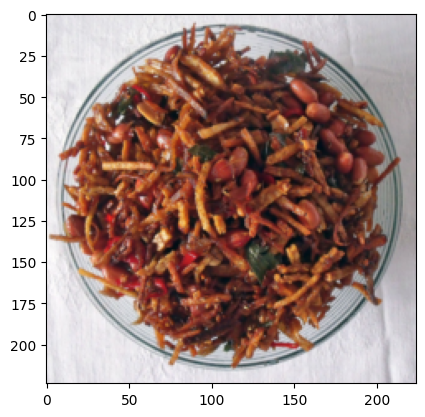

In [56]:
imshow(train_dataset[10][0])


In [75]:
#from torchvision import models
from torchvision.models import resnet18, resnet50, ResNet50_Weights

model1 = resnet18(pretrained = True)
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Batch size: train set  
batch_size = 50

# Learning rate  
lr = 5e-3

# Number epochs 
n_epochs = 10
# resnet18 (fc): Linear(in_features=512, out_features=1000, bias=True)
# resnet50 (fc): Linear(in_features=2048, out_features=1000, bias=True)


In [76]:
from torch.nn import Linear

for param in model.parameters():
    param.requires_grad = False

# Next, we set `n_classes` to the number of classes we have. 
# Recall that we have two classes: "hotdog" and "not hotdog".
n_classes = dataset.n_classes

# Now that we have those parameters set, we can replace the output layer, 
# `model.fc` of the neural network, with a `nn.Linear` object to classify 
# `n_classes`'s different classes. For the first parameter, known as **in_features**, 
# we input 512 because the second last hidden layer of the neural network 
# has 512 neurons.
model.fc = Linear(2048, n_classes)

In [77]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

In [78]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr = lr)

In [79]:
trainer = ClassificationModelTrainer(model,
                                     train_dataset,
                                     val_dataset,
                                     batch_size,
                                     criterion,
                                     optimizer,)

In [82]:
trainer.train_model(n_epochs)






































































































































100%|██████████| 120/120 [15:53<00:00,  7.94s/it, Training Loss=1.01, Validation Accuracy=0.82, Epoch=10]


  0%|          | 0/24 [54:02<?, ?it/s, Training Loss=Not yet available, Validation Accuracy=Not yet available, Epoch=1]


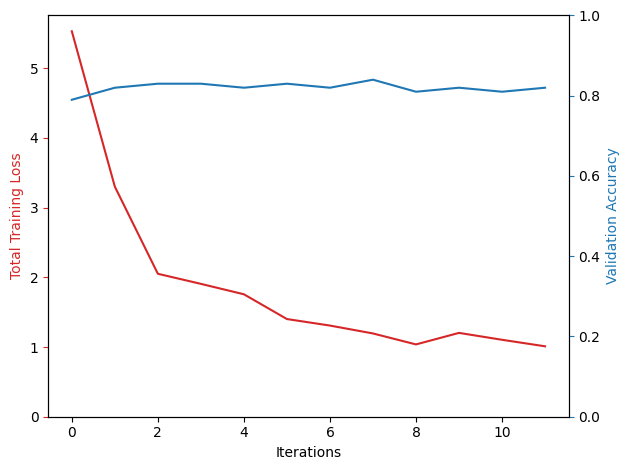

In [83]:
trainer.plot_training_stat()

In [ ]:
accuracy = trainer.test(test_dataset)
print(accuracy)

In [85]:
print(f"The model reached an accuracy rate of {accuracy:.2f}% on images it has never seen before.")

The model reached an accuracy rate of 85.15% on images it has never seen before.


In [90]:
trainer.dump_to("saved_model.pth")

In [15]:
import torch
from torch.nn import Linear
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
import torchvision.models as models

# Function to preprocess an image from a URL
def preprocess_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

# Load the saved model
model = models.resnet50(pretrained=False)
model.fc = Linear(2048, 2)
model.load_state_dict(torch.load("saved_model.pth")['model_params'])
model.eval()


# Function to perform inference using the loaded model
def perform_inference(model, image):
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities).item()
    confidence = probabilities[0, predicted_class].item()
    return predicted_class, confidence

# URL of the image from the web
image_url = 'https://cdn1-production-images-kly.akamaized.net/uNkYubvtEPM3S8pki06u1jO50-A=/958x0:3209x3000/469x625/filters:quality(75):strip_icc():format(webp)/kly-media-production/medias/2734642/original/063217000_1550735158-2019-02-20.jpg'

# Preprocess the image
image = preprocess_image(image_url)

# Perform inference
predicted_class, confidence = perform_inference(model, image)

# Output the results
print(f"Predicted Class: {predicted_class}, Confidence: {confidence}")


Predicted Class: 1, Confidence: 0.94789057970047
